In [66]:
import numpy as np
from tic_env import TictactoeEnv
from optimal_player import OptimalPlayer
from network import DQN
from collections import namedtuple, deque
import random
import matplotlib
from epsilon_strategy import ConstantEpsilon, DecreasingEpsilon
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from metrics import compute_m_opt, compute_m_rand
import torch.nn.functional as F
import torchvision.transforms as T
import abc
from loguru import logger
import agent
from agent import Agent
from policy import EpsilonGreedy
from  utils import represent_gird_as_state, from_int_to_tuple_repr, from_tuple_to_int
from replay_memory import ReplayMemory, Transition
import sys
from trainer import Trainer
logger.remove()
logger.add(sys.stderr, level="INFO")
from self_trainer import SelfPracticeTrainer

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
np.random.seed(1)
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary ε ∈ [0, 1) against Opt(0.5) for 20’000 games – switch the 1st player after every game.
Question 11. Plot average reward and average training loss for every 250 games during training. Does the loss decrease? Does the agent learn to play Tic Tac Toe?
Expected answer: A figure with two subplots (caption length < 50 words). Specify your choice of ε.

In [71]:
opponent_epsilon = 0.5
agent_epsilon = 0.1
dqn = DQN(device).to(device)
replay_memory = ReplayMemory(10_000, 64)
trainer = Trainer(
    dqn,
    OptimalPlayer(opponent_epsilon),
    EpsilonGreedy(dqn, ConstantEpsilon(agent_epsilon), 9, device, logger),
    replay_memory,
)

In [72]:
trainer.init_replay_memory()
trainer.training_loop()

2022-06-06 18:05:55.058 | INFO     | trainer:init_replay_memory:112 - Initialize Replay Memory
  6%|▌         | 1158/20000 [00:21<05:56, 52.82it/s]


KeyboardInterrupt: 

In [ ]:
trainer.plot_avg_loss_reward()

Question 12. Repeat the training but without the replay buffer and with a batch size of 1: At every step, update the network by using only the latest transition. What do you observe?
Expected answer: A figure with two subplots showing average reward and average training loss during training (caption length < 50 words).

In [73]:
opponent_epsilon = 0.5
agent_epsilon = 0.1
dqn =DQN(device).to(device)
batch_size = 1
replay_memory = ReplayMemory(1, 1)
trainer_batch_one = Trainer(
    dqn,
    OptimalPlayer(opponent_epsilon),
    EpsilonGreedy(dqn, ConstantEpsilon(agent_epsilon), 9, device, logger),
    replay_memory,
    batch_size=batch_size
)

In [74]:
trainer_batch_one.init_replay_memory()
trainer_batch_one.training_loop()

2022-06-06 18:08:38.058 | INFO     | trainer:init_replay_memory:112 - Initialize Replay Memory
100%|██████████| 20000/20000 [04:55<00:00, 67.71it/s] 


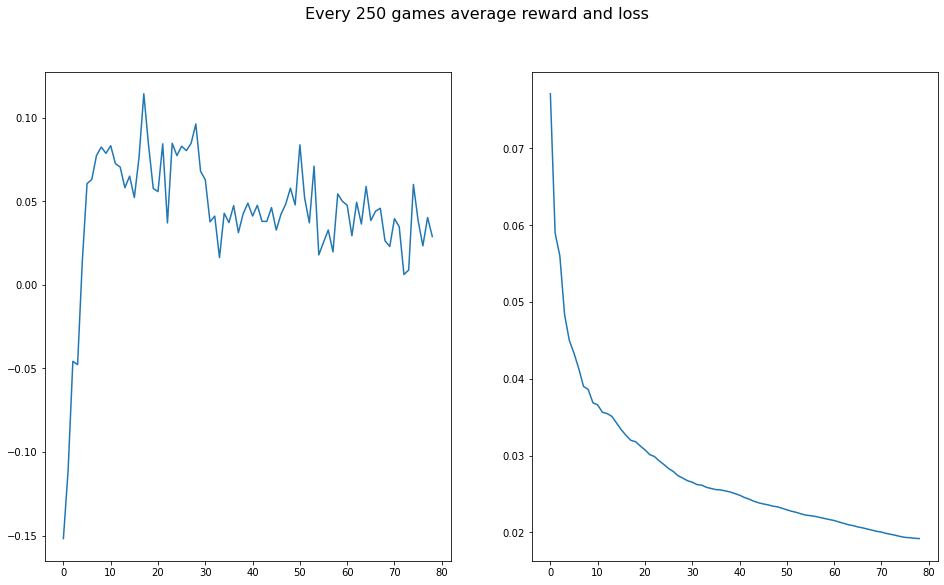

In [11]:
trainer_batch_one.plot_avg_loss_reward()

Instead of fixing ε, use ε(n) in Equation 1. For different values of n∗, run your DQN against Opt(0.5) for 20’000 games – switch the 1st player after every game. Choose several values of n∗ from a reasonably wide interval between 1 to 40’000 – particularly, include n∗ = 1.

In [12]:
n_stars = np.linspace(1, 40_000, 5).astype(np.int32)
n_stars

array([    1, 10000, 20000, 30000, 40000], dtype=int32)

In [13]:
trainers = []
for n_star in n_stars:
    opponent_epsilon = 0.5
    agent_epsilon = 0.1
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 10_000)
    temp_trainer = Trainer(
        dqn,
        OptimalPlayer(opponent_epsilon),
        EpsilonGreedy(dqn, DecreasingEpsilon(0.1, 0.8, n_star), 9, device, logger),
        replay_memory,
        "",
        batch_size=batch_size
    )
    trainers.append(temp_trainer)


In [14]:
for t in trainers:
    t.init_replay_memory()
    t.training_loop()

2022-06-06 09:10:22.334 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [05:20<00:00, 62.31it/s] 
2022-06-06 09:15:43.391 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [06:10<00:00, 54.05it/s] 
2022-06-06 09:21:53.459 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [06:09<00:00, 54.09it/s] 
2022-06-06 09:28:03.291 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [06:09<00:00, 54.19it/s] 
2022-06-06 09:34:12.391 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [05:58<00:00, 55.74it/s] 


Question 13. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?
Expected answer: A figure showing Mopt and Mrand over time for different values of speeds of n∗ (caption length < 250 words).

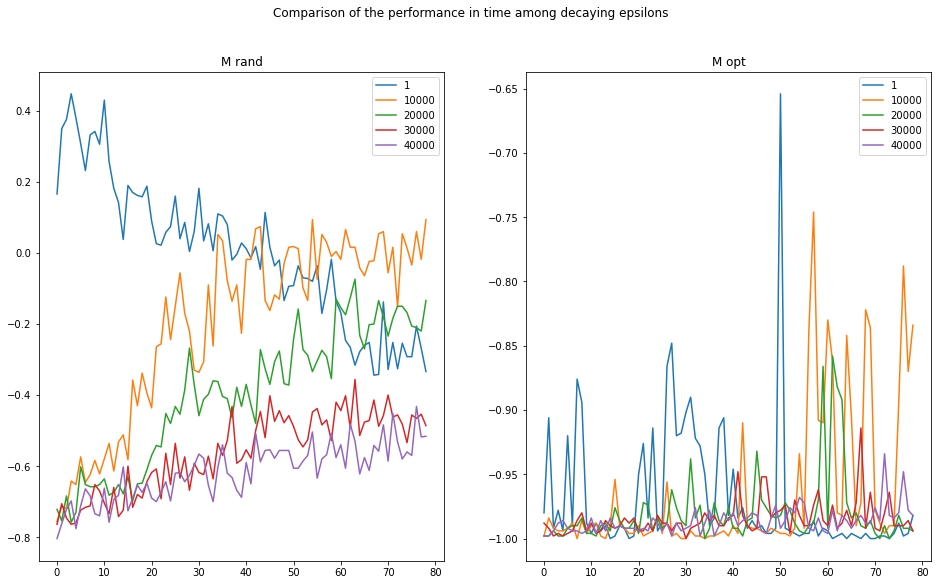

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance in time among decaying epsilons")
ax1.set_title("M rand")
ax2.set_title("M opt")
for n_star, t in zip(n_stars, trainers):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(n_star))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(n_star))
    ax2.legend()

Choose the best value of n∗ that you found. Run DQN against Opt(εopt) for different values of εopt for 20’000 games – switch the 1st player after every game. Choose several values of εopt from a reasonably wide interval between 0 to 1 – particularly, include εopt = 0.
Question 14. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents 4
– for each value of εopt. Plot Mopt and Mrand over time. What do you observe? How can you explain it? Expected answer: A figure showing Mopt and Mrand over time for different values of εopt (caption length < 250 words).

In [34]:
n_star = 10_000

trainers_with_best_n_star = []
ops_epsilons = np.linspace(0, 1, 5)
for op_eps in ops_epsilons:
    agent_epsilon = 0.1
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 10_000)
    temp_trainer = Trainer(
        dqn,
        OptimalPlayer(op_eps),
        EpsilonGreedy(dqn, DecreasingEpsilon(0.1, 0.8, n_star), 9, device, logger),
        replay_memory,
        "",
        batch_size=batch_size
    )
    trainers_with_best_n_star.append(temp_trainer)

In [35]:
for t in trainers_with_best_n_star:
    t.init_replay_memory()
    t.training_loop()

2022-06-06 12:12:55.364 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [05:20<00:00, 62.50it/s] 
2022-06-06 12:18:15.477 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [05:10<00:00, 64.49it/s] 
2022-06-06 12:23:25.653 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [05:25<00:00, 61.44it/s] 
2022-06-06 12:28:51.201 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [05:45<00:00, 57.92it/s] 
2022-06-06 12:34:36.573 | INFO     | trainer:init_replay_memory:115 - Initialize Replay Memory
100%|██████████| 20000/20000 [06:03<00:00, 55.09it/s] 


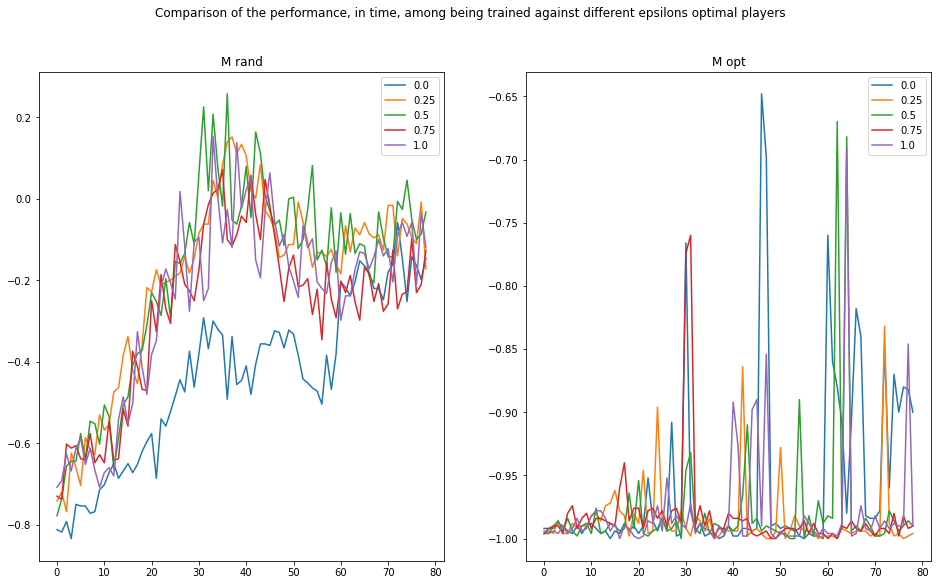

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance, in time, among being trained against different epsilons optimal players")
ax1.set_title("M rand")
ax2.set_title("M opt")
for eps, t in zip(ops_epsilons, trainers_with_best_n_star):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(eps))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(eps))
    ax2.legend()

Question 15. What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

In [39]:
max_m_opt = -np.infty
max_m_rand = -np.infty
for eps, t in zip(ops_epsilons, trainers_with_best_n_star):
    max_m_opt = max(t.m_opt) if max(t.m_opt) > max_m_opt else max_m_opt
    max_m_rand = max(t.m_rand) if max(t.m_rand) > max_m_rand else max_m_rand
print(f"Max M opt is {max_m_opt}")
print(f"Max M rand is {max_m_rand}")


Max M opt is -0.648
Max M rand is 0.258


## Learning by self-practice

For different values of ε ∈ [0, 1), run a DQN agent against itself for 20’000 games – i.e. both players use the same neural network and share the same replay buffer.

Question 16. After every 250 games during training, compute the ‘test’ Mopt and Mrand for different values of ε ∈ [0, 1). Plot Mopt and Mrand over time. Does the agent learn to play Tic Tac Toe? What is the effect of ε?
Expected answer: A figure showing Mopt and Mrand over time for different values of ε ∈ [0, 1) (caption length < 100 words).

In [42]:
opponent_epsilon = 0.5
agent_epsilon = 0.1
dqn =DQN(device).to(device)
batch_size = 1
replay_memory = ReplayMemory(10_000, 64)
trainer_self_practice = SelfPracticeTrainer(
    dqn,
    OptimalPlayer(opponent_epsilon),
    EpsilonGreedy(dqn, ConstantEpsilon(agent_epsilon), 9, device, logger),
    replay_memory,
    batch_size=batch_size
)

In [43]:
trainer_self_practice.init_replay_memory()
trainer_self_practice.training_loop()

2022-06-06 13:07:31.736 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [06:25<00:00, 51.87it/s] 


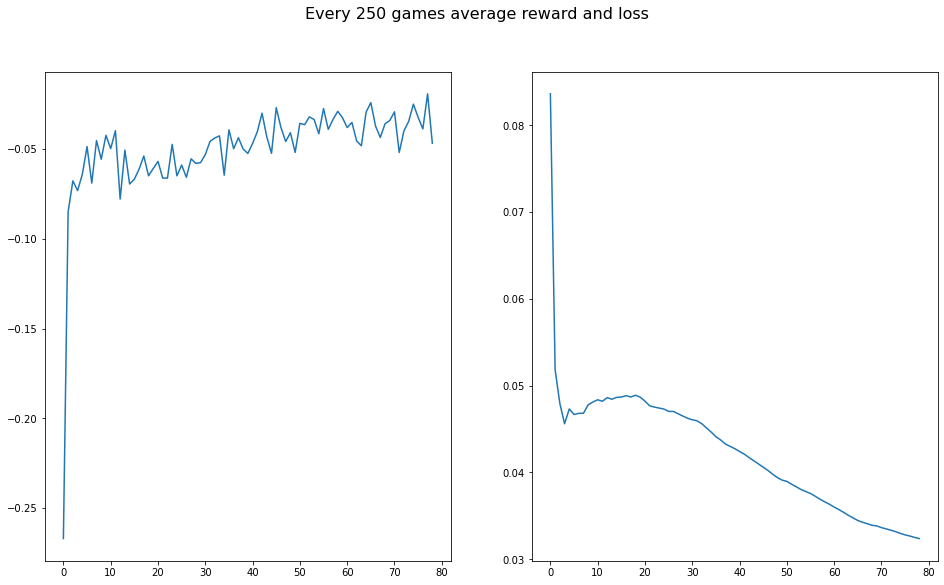

In [46]:
trainer_self_practice.plot_avg_loss_reward()

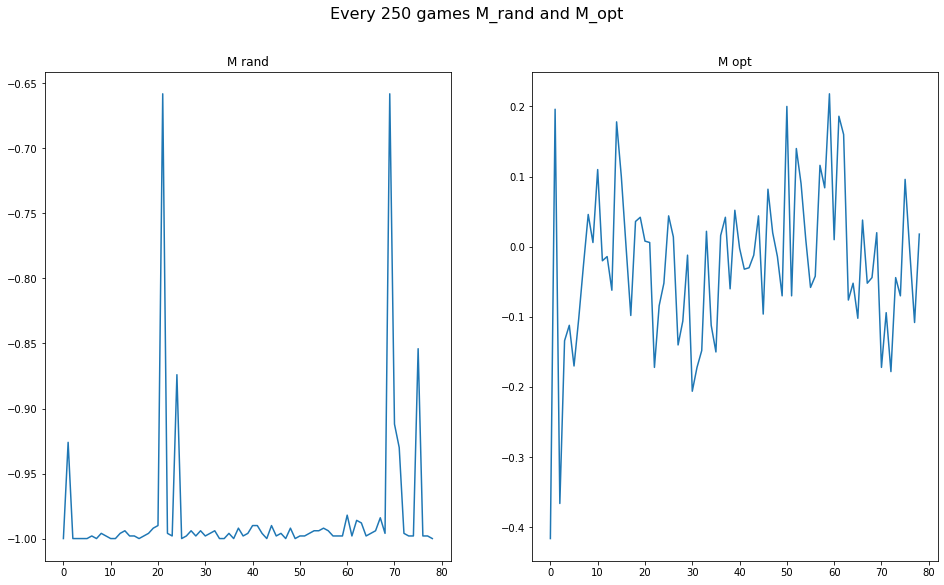

In [48]:
trainer_self_practice.plot_m_metrics()

Instead of fixing ε, use ε(n) in Equation 1 with different values of n∗.
Question 17. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?
Expected answer: A figure showing Mopt and Mrand over time for different values of speeds of n∗ (caption length < 100 words).

In [62]:
n_stars = np.linspace(1, 40_000, 5).astype(np.int32)
n_stars = np.append(n_stars, np.array([100, 1_000, 2_000, 4_000, 6_000, 8_000]))
n_stars

array([    1, 10000, 20000, 30000, 40000,   100,  1000,  2000,  4000,
        6000,  8000])

In [63]:
self_practice_eps_dec_trainers = []
for n_star in n_stars:
    opponent_epsilon = 0.5
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 64)
    temp_trainer = SelfPracticeTrainer(
        dqn,
        OptimalPlayer(opponent_epsilon),
        EpsilonGreedy(dqn, DecreasingEpsilon(0.1, 0.8, n_star), 9, device, logger),
        replay_memory,
        batch_size=batch_size
    )
    self_practice_eps_dec_trainers.append(temp_trainer)

In [64]:
for t in self_practice_eps_dec_trainers:
    t.init_replay_memory()
    t.training_loop()

2022-06-06 14:23:36.482 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [08:24<00:00, 39.68it/s]
2022-06-06 14:32:00.587 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [10:08<00:00, 32.87it/s] 
2022-06-06 14:42:09.062 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [07:17<00:00, 45.72it/s] 
2022-06-06 14:49:26.489 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [06:56<00:00, 48.01it/s] 
2022-06-06 14:56:23.063 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [07:14<00:00, 46.04it/s] 
2022-06-06 15:03:37.528 | INFO     | self_trainer:init_replay_memory:114 - Initialize Replay Memory
100%|██████████| 20000/20000 [09:00<00:00, 37.01it/s] 
2022-06-06 15:12:38.012 | INFO     | self_trainer:init_replay_memory:11

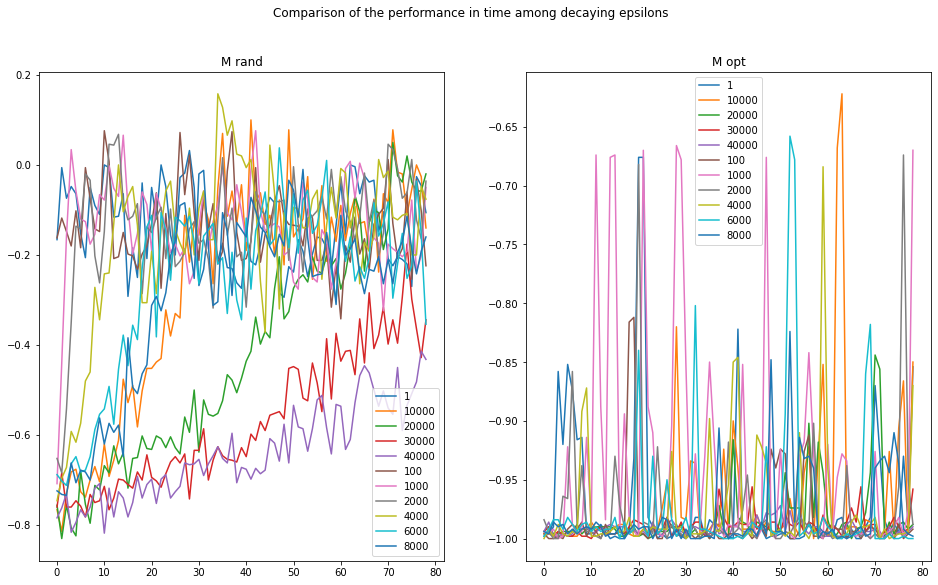

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance in time among decaying epsilons")
ax1.set_title("M rand")
ax2.set_title("M opt")
for n_star, t in zip(n_stars, self_practice_eps_dec_trainers):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(n_star))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(n_star))
    ax2.legend()

Question 18. What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

In [ ]:
max_m_opt = -np.infty
max_m_rand = -np.infty
for n_star, t in zip(n_stars, self_practice_eps_dec_trainers):
    max_m_opt = max(t.m_opt) if max(t.m_opt) > max_m_opt else max_m_opt
    max_m_rand = max(t.m_rand) if max(t.m_rand) > max_m_rand else max_m_rand
print(f"Max M opt is {max_m_opt}")
print(f"Max M rand is {max_m_rand}")

Question 19. For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?
Expected answer: A figure with 3 subplots of 3 different states with Q-values shown at available actions (caption length < 200 words).